In [1]:
# 這個Jupyter Notebook的環境
import platform
import tensorflow
import keras
print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from IPython.display import Image

C:\Users\Java\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Platform: Windows-10-10.0.16299-SP0
Tensorflow version: 1.5.0
Keras version: 2.1.3


In [2]:
import os, shutil
# 專案的根目錄路徑
os.chdir('D:\\BB105Project\\dogrecognition\\Model')

ROOT_DIR = os.getcwd()

print(os.getcwd())

breed_dir =  os.listdir('data\\train')[:16]


# 置放coco圖像資料與標註資料的目錄
DATA_PATH = os.path.join(ROOT_DIR, "data")

# 原始數據集的路徑 ./data/train
original_dataset_dir = os.path.join(DATA_PATH, "select_train")

# 存儲小數據集的目錄 ./data/cats_and_dogs_small
base_dir = os.path.join(DATA_PATH, "dog_breed")
if not os.path.exists(base_dir): 
    os.mkdir(base_dir)
    
#----------------------------------------------------------

# 我們的訓練資料的目錄 ./data/cats_and_dogs_small/train
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): 
    os.mkdir(train_dir)

# 我們的驗證資料的目錄 ./data/cats_and_dogs_small/validation
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir): 
    os.mkdir(validation_dir)

# 我們的測試資料的目錄 ./data/cats_and_dogs_small/test
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
    
#----------------------------------------------------------  

# 狗種的圖片的訓練資料目錄 ./data/cats_and_dogs_small/train/cats
for breed in breed_dir:
    train_cats_dir = os.path.join(train_dir, breed)
    if not os.path.exists(train_cats_dir):
        os.mkdir(train_cats_dir)

    
# 狗種的圖片的驗證資料目錄 ./data/cats_and_dogs_small/validation/cats
for breed in breed_dir:
    validation_cats_dir = os.path.join(validation_dir, breed)
    if not os.path.exists(validation_cats_dir):
        os.mkdir(validation_cats_dir)

    
# 狗種的圖片的測試資料目錄 ./data/cats_and_dogs_small/test/cats
for breed in breed_dir:
    test_cats_dir = os.path.join(test_dir, breed)
    if not os.path.exists(test_cats_dir):
        os.mkdir(test_cats_dir)
    
#----------------------------------------------------------

# 複製前400個狗種的圖片到train_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    train_path = os.path.join(train_dir,breed)
    fnames = os.listdir(breed_path)[:200]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(train_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy first 200 breed images to train_breed_dir complete!')

# 複製下100個狗種的圖片到validation_cats_dir
for breed in breed_dir:
    breed_path = os.path.join(original_dataset_dir,breed)
    validation_path = os.path.join(validation_dir,breed)
    fnames = os.listdir(breed_path)[200:250]
    for fname in fnames:
        src = os.path.join(breed_path, fname)
        dst = os.path.join(validation_path, fname)
        if not os.path.exists(dst):
            shutil.copyfile(src, dst)

print('Copy next 50 brees images to validation_breed_dir complete!')

# 複製下500個貓的圖片到test_cats_dir
#fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
#for fname in fnames:
#    src = os.path.join(original_dataset_dir, fname)
#    dst = os.path.join(test_cats_dir, fname)
#    if not os.path.exists(dst):
#        shutil.copyfile(src, dst)

#print('Copy next 500 cat images to test_cats_dir complete!')



#print('total training cat images:', len(os.listdir(train_cats_dir)))
#print('total training dog images:', len(os.listdir(train_dogs_dir)))
#print('total validation cat images:', len(os.listdir(validation_cats_dir)))
#print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
#print('total test cat images:', len(os.listdir(test_cats_dir)))
#print('total test dog images:', len(os.listdir(test_dogs_dir)))

D:\BB105Project\dogrecognition\Model
Copy first 200 breed images to train_breed_dir complete!
Copy next 50 brees images to validation_breed_dir complete!


# 特徵提取 (feature extraction)
特徵提取包括了使用預訓練好的網絡模型來從新樣本中提取特徵。這些特徵通過一個"新"的分類器(從頭開始訓練)。

實例化一個VGG16模型：

In [3]:
from keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                     include_top=False, # 在這裡告訴 keras我們只需要卷積基底的權重模型資訊
                     input_shape=(150,150,3)) # 宣告我們要處理的圖像大小與顏色通道數

我們向構造函數傳遞了三個參數：

weights, 指定從哪個權重檢查點從中初始化模型

include_top, 這是指在網絡頂部要包括或不包含密集連接的分類器。默認情況下，這個密集連接的分類器將對應於ImageNet的1000個類別。因為我們打算用自己建構的分類器（只有兩個類別，貓和狗），因此我們不需要包括它。

input_shape, 我們將餵進到網絡的圖像張量的形狀(shape)。這個參數純粹是可選的：如果我們設定，那麼網絡將能夠處理任何大小的輸入。
以下是VGG16“卷積基底”架構的細節：它與您已經熟悉的簡單卷積網絡(convnets)非常相似。

In [4]:
conv_base.summary() # 打印一下模型資訊

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## 方法2: (卷積基底:凍結 + 串接新的密集分類層) >> 重新訓練

現在，我們來回顧一下我們提到的第二種特徵提取技術，這種方法要慢得多，而且會花更多的時間與計算資源，但是我們可以在訓練過程中利用數據擴充(data augmentation): 擴展conv_base模型，並進行端(end)對端(end)的訓練。

請注意，這種手法真的是非常昂貴的，所以只有在你有GPU時才應該嘗試它：在CPU上是絕對棘手的。如果您無法在GPU上運行代碼，那麼前一個手法就是你要選的路。

因為模型的行為就像堆積木，所以你可以添加一個模型（像我們的conv_base）到Sequential模型，就像添加一個圖層一樣。所以你可以執行以下操作：

### 移花+接木

In [5]:
from keras import models
from keras import layers

model = models.Sequential() # 產生一個新的網絡模型結構
model.add(conv_base)        # 把預訓練的卷積基底疊上去
model.add(layers.Flatten()) # 打平
model.add(layers.Dense(256, activation='relu'))  # 疊上新的密集連接層來做為分類器
model.add(layers.Dense(16, activation='softmax')) # 因為我的資料集只有兩類(cat & dog)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 33,973,048
Trainable params: 33,918,520
Non-trainable params: 54,528
_________________________________________________________________


In [7]:
# 看一下“凍結前”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [8]:
# “凍結”卷積基底
conv_base.trainable = False

In [9]:
# 再看一下“凍結後”有多少可以被訓練的權重
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import datetime as dt
start = dt.datetime.now()

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# 請注意: 驗證用的資料不要進行資料的增強
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 圖像資料的目錄
        train_dir,
        # 設定圖像的高(height)與寬(width)
        target_size=(150, 150),
        batch_size=50,
        # 因為我們的目標資料集只有兩類(cat & dog)
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=50,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Found 3196 images belonging to 16 classes.
Found 703 images belonging to 16 classes.
Epoch 1/30
100/100 [==============================] - 166s 2s/step - loss: 1.7393 - acc: 0.4824 - val_loss: 0.6201 - val_acc: 0.8338
Epoch 2/30
100/100 [==============================] - 85s 854ms/step - loss: 1.2538 - acc: 0.6197 - val_loss: 0.5930 - val_acc: 0.8512
Epoch 3/30
100/100 [==============================] - 85s 847ms/step - loss: 1.1141 - acc: 0.6674 - val_loss: 0.5633 - val_acc: 0.8568
Epoch 4/30
100/100 [==============================] - 87s 865ms/step - loss: 1.0642 - acc: 0.6716 - val_loss: 0.5670 - val_acc: 0.8682
Epoch 5/30
100/100 [==============================] - 86s 857ms/step - loss: 1.0168 - acc: 0.6882 - val_loss: 0.6354 - val_acc: 0.8601
Epoch 6/30
100/100 [==============================] - 85s 848ms/step - loss: 0.9811 - acc: 0.6974 - val_loss: 0.7280 - val_acc: 0.8356
Epoch 7/30
100/100 [==============================] - 86s 858ms/step - loss: 0.9678 - acc: 0.7029 - val_los

In [11]:
model.save('breed16_Xception_1.h5') # 把模型儲存到檔案

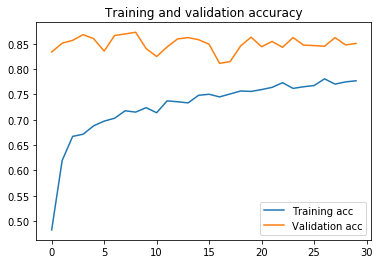

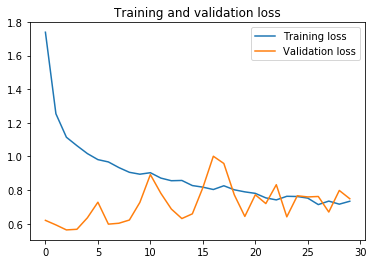

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 微調 (fine-tuning)

另一種廣泛使用的模型重覆利用技術，與_特徵提取(feature extraction)_相輔相成，是 _(微調) fine-tuning_。

微調包括解凍用於特徵提取的凍結模型庫中的幾個頂層(top layers)，並且共同訓練新添加的模型部分（在我們的範例中是完全連接的分類器）和這些頂層。這被稱為“微調(fine-tuning)”，因為它稍微調整正在重複使用的模型中更抽象的表示，以使它們與當前的要處理的問題更相關。

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In [13]:
conv_base.trainable = True # 解凍 "卷積基底"

# 所有層直到block4_pool都應該被凍結，而'block14_sepconv2','block14_sepconv2_bn', 'block14_sepconv2_act'則被解凍        
layers_frozen = ['block14_sepconv1','block14_sepconv1_bn', 'block14_sepconv1_act','block14_sepconv2','block14_sepconv2_bn', 'block14_sepconv2_act']
for layer in conv_base.layers:
    if layer.name in layers_frozen:
        layer.trainable = True
    else:
        layer.trainable = False
        
# 把每一層是否可以被"trainable"的flat打印出來
for layer in conv_base.layers:
    print("{}: {}".format(layer.name, layer.trainable))

input_1: False
block1_conv1: False
block1_conv1_bn: False
block1_conv1_act: False
block1_conv2: False
block1_conv2_bn: False
block1_conv2_act: False
block2_sepconv1: False
block2_sepconv1_bn: False
block2_sepconv2_act: False
block2_sepconv2: False
block2_sepconv2_bn: False
conv2d_1: False
block2_pool: False
batch_normalization_1: False
add_1: False
block3_sepconv1_act: False
block3_sepconv1: False
block3_sepconv1_bn: False
block3_sepconv2_act: False
block3_sepconv2: False
block3_sepconv2_bn: False
conv2d_2: False
block3_pool: False
batch_normalization_2: False
add_2: False
block4_sepconv1_act: False
block4_sepconv1: False
block4_sepconv1_bn: False
block4_sepconv2_act: False
block4_sepconv2: False
block4_sepconv2_bn: False
conv2d_3: False
block4_pool: False
batch_normalization_3: False
add_3: False
block5_sepconv1_act: False
block5_sepconv1: False
block5_sepconv1_bn: False
block5_sepconv2_act: False
block5_sepconv2: False
block5_sepconv2_bn: False
block5_sepconv3_act: False
block5_sepco

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5), # 使用小的learn rate
              metrics=['acc'])

start = dt.datetime.now()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50)

end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))

Epoch 1/50
100/100 [==============================] - 93s 931ms/step - loss: 0.6664 - acc: 0.7970 - val_loss: 0.6595 - val_acc: 0.8139
Epoch 2/50
100/100 [==============================] - 91s 913ms/step - loss: 0.6679 - acc: 0.7903 - val_loss: 0.6333 - val_acc: 0.8207
Epoch 3/50
100/100 [==============================] - 91s 906ms/step - loss: 0.6510 - acc: 0.7970 - val_loss: 0.6432 - val_acc: 0.8175
Epoch 4/50
100/100 [==============================] - 91s 912ms/step - loss: 0.6261 - acc: 0.8058 - val_loss: 0.6339 - val_acc: 0.8198
Epoch 5/50
100/100 [==============================] - 91s 912ms/step - loss: 0.6158 - acc: 0.8047 - val_loss: 0.6329 - val_acc: 0.8245
Epoch 6/50
100/100 [==============================] - 90s 904ms/step - loss: 0.5811 - acc: 0.8217 - val_loss: 0.5946 - val_acc: 0.8361
Epoch 7/50
100/100 [==============================] - 91s 914ms/step - loss: 0.5787 - acc: 0.8207 - val_loss: 0.6204 - val_acc: 0.8156
Epoch 8/50
100/100 [==============================] - 9

In [15]:
model.save('breed16_Xception_tunning_1.h5')

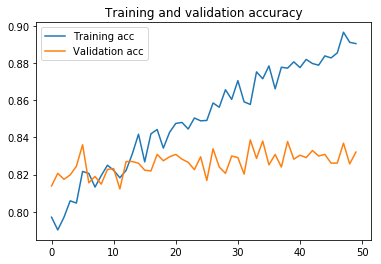

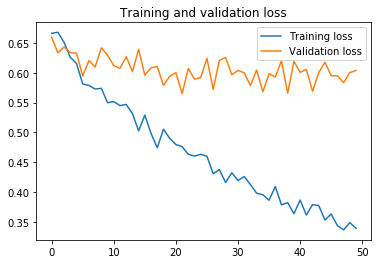

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

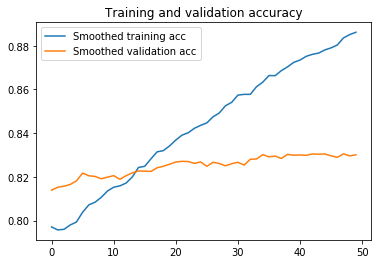

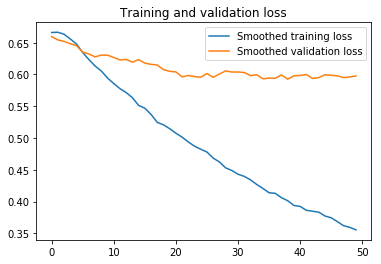

In [19]:
plt.plot(epochs,
         smooth_curve(acc), label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()